# Using Q-learning to optimise communication with customers

### Background
Most daily mailers from ecommerce companies are sent at a set time every day. The average response (open rate, to be precise) of these emails for one such company, over the course of 6 months, is between 22% and 43%, based on the day and time that the email is sent.

### Interesting reads:

https://blog.hubspot.com/marketing/best-time-to-send-email

http://customer.io/blog/timing-week-day-email-sending-schedule.html

https://customer.io/blog/best-time-to-send-email/

### Hypothesis
If the emails are sent to customers at a time when they are most active, and therefore more likely to open and resopnd to an email, we can increase the response rate of the customer base. 

### Goal
We want to use a customer base that we know nothing about. This means that we have no historical data of the customers. This would be particularly useful to new ecommerce companies, or companies where the customer base changes frequently. Therefore, Reinforcement Learning seems like a suitable approach for this problem. In particular, we will use Q-learning. Q-learning is lighweight, and the problem is small enough that experiments should not take too long to conduct. We would also like our algorithm to train within a matter of months, and we'll only allow the algorithm to send one email per day.

### The dataset:
The dataset we'll use is obtained from a real ecommerce company. The set contains about 100 "activity" graphs generated from historical customer data. These graphs indicate when a customer is most likely to be active on their emails (based on previous responses). Therefore, we can use these graphs to model the environment (customer) in our problem. Unfortunately, these graphs are in .png format, which means they first need to be processed to a usable form before they can be used to model the environment. In addition, the dataset is fairly small, so to test our algorithm on larger customer databases, we'll need some form of generative model to build a larger, mostly synthetic database.

### Q-learning basics

Q-learning is one of the more basic and early developed algorithms for Reinforcement Learning, or RL. RL is branch of machine learning that deals with learning from an environment and it's dynamics, rather than a dataset and it's properties. This means that with RL, we can start experimenting on any given customer base without knowing anything about this customer base. In fact, we can use prior knowledge of the customer base to boost the learning process, but more on this later. Q-learning employs a simple system: We explore at the start of the problem, and then gradually move into the "control" phase, updating the value of each action based on the reward received from that action. Our experiment has a simple setup:

- The agent (algorithm) can choose a single time at which to send an email to each customer individually, once per day.
- The email opens are recorded.
- The agent will receive a reward of 1000 for an email open, -100 for an ignore, and 0 if it decides not to send an email (for opted out customers).
- We will then gradually update what we know about customers using these rewards, and eventually figure out when the best time is to send emails to each individual customer.
- Hopefully this will boost our engagement and email open rate.

### 1. Convert the .png's obtained from data source to usable data

In [3]:
#Imports and such
import csv
import glob
from PIL import Image
import PIL.ImageOps as ImageOps
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
import random
from torch import nn
import torch
from collections import deque

%matplotlib inline

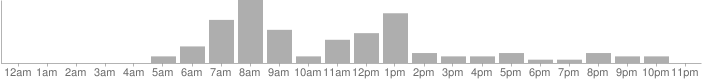

In [4]:
#Open and display example image in greyscale
img = Image.open('graph-digitization/example.png').convert('L')
display(img)

In [5]:
#Convert to array of pixel values
pix = np.array(img.getdata()).reshape(img.size[1], img.size[0])
print(pix)

[[255 217 255 ... 255 255 255]
 [255 179 255 ... 255 255 255]
 [255 179 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


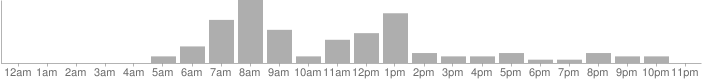

In [6]:
#Just so we can make sure our image is still what it used to be
display(Image.fromarray(pix.astype('uint8'), 'L'))

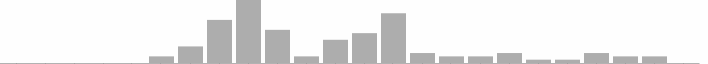

In [7]:
#Crop image to get rid of stuff we don't need
cropped_pix = np.delete(pix, np.s_[0:2], axis=1)
cropped_pix = np.delete(cropped_pix, np.s_[cropped_pix.shape[0] - 18:cropped_pix.shape[0]], axis=0)

#Display to check crop
display(Image.fromarray(cropped_pix.astype('uint8')+255, 'L'))

#Invert the image
cropped_pix = 255-cropped_pix

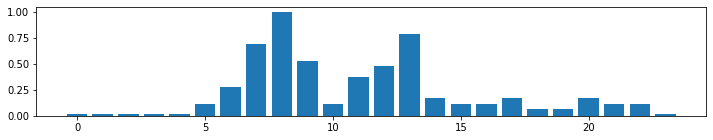

In [8]:
#Extract vertical "bars" from image pixel array
bars = []
average_bars = []
for i in range(24):
    bars.append(cropped_pix[:,int((i*cropped_pix.shape[1])/24)+10])

#Calculate average pixel value from each bar, as this will correspond to the average height of that bar
for bar in bars:
    average_bars.append(np.mean(bar))

#Normalise
average_bars = average_bars/np.max(average_bars)

#Plot to check data
plt.figure(figsize=(12, 2))
plt.bar(range(0,24), average_bars)
plt.show()

#Maybe convert this to a histogram

### Let's test this as a function

In [9]:
def image_to_graph(image_path, crop_left, crop_bottom, bar_offset):
    
    img = Image.open(image_path).convert('L')
    pix = np.array(img.getdata()).reshape(img.size[1], img.size[0])
    #print("Greyscale image")
    #display(Image.fromarray(pix.astype('uint8'), 'L'))
    
    #Crop image to get rid of stuff we don't need
    cropped_pix = np.delete(pix, np.s_[0:crop_left], axis=1)
    cropped_pix = np.delete(cropped_pix, np.s_[cropped_pix.shape[0] - crop_bottom:cropped_pix.shape[0]], axis=0)

    #Display to check crop
    #print("Cropped image")
    #display(Image.fromarray(cropped_pix.astype('uint8')+255, 'L'))

    #Invert the image
    cropped_pix = 255-cropped_pix
    
    #Extract vertical "bars" from image pixel array
    bars = []
    average_bars = []
    for i in range(24):
        bars.append(cropped_pix[:,int((i*cropped_pix.shape[1])/24)+bar_offset])

    #Calculate average pixel value from each bar, as this will correspond to the average height of that bar
    for bar in bars:
        average_bars.append(np.mean(bar))
    
    #Normalise to 1.0
    #average_bars = average_bars/np.max(average_bars)
    
    #Plot to check data
    #print("Extracted data")
    #plt.figure(figsize=(12, 2))
    #plt.bar(range(0,24), average_bars)
    #plt.show()
    #print("\n\n")
    
    return average_bars


def write_to_csv(files, filename):

    # open the file in the write mode
    f = open(filename, 'w')

    # create the csv writer
    writer = csv.writer(f)

    for i in range(len(files)):
        print("Graph nr", str(i+1))
        writer.writerow(image_to_graph(files[i], 2, 20, 10))

    f.close()

# All files and directories ending with .txt and that don't begin with a dot:
files = glob.glob("./graph-digitization/charts/*.png")


In [10]:
data = []
for file in files:
    data.append(image_to_graph(file, 2, 20, 10))
data = np.asarray(data)
data.shape

(124, 24)

### 2. Use a generative model to generate synthetic activitiy data from the distribution defined by the small dataset

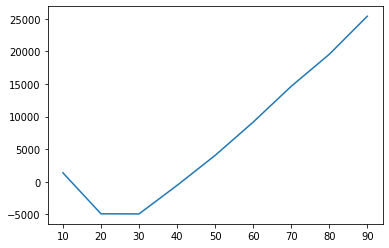

In [11]:
n_components = np.arange(10, 100, 10)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [12]:
gmm = mixture.GaussianMixture(80, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now that we have a trained GMM, we can use it to generate any number of customer activity examples, which will be representative of the small dataset initially used to train the GMM. It will definitely be useful to have more data for the training process. We would also like to be able to write the new customer data to a .csv file, so it can be reused for further investigation.

In [13]:
def write_raw_data_to_csv(gmm, filename='synthetic_raw_data.csv'):
    data_new = gmm.sample(100)[0]
    #data_new_arr = np.asarray(data_new)
    #print(data_new)

    # open the file in the write mode
    f = open(filename, 'w')

    # create the csv writer
    writer = csv.writer(f)

    for i in range(len(data_new)):
        writer.writerow(data_new[i])

    f.close()

### 3. Generate a response probability from the generated data

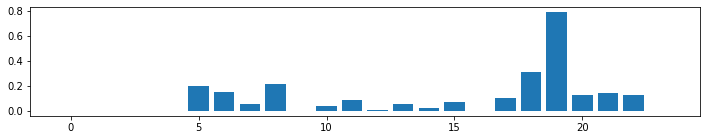

In [22]:
def histogram_to_probability(histogram):
    return histogram/100.0

test = gmm.sample(10)[0][random.randint(0,9)]
plt.figure(figsize=(12, 2))
plt.bar(range(0,24), test/100)
plt.show()
#plt.plot(histogram_to_probability(test), color='r')

### 4.Generate 1000 customers, and then test the response rate
The idea here is to see whether or not our processing of the customer data actually corresponds to the response rate of real customer base.

In [13]:
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]

NUM_DAYS_TO_TEST = 100
time_for_first_mailer = 5
avg_responses = []

for i in range(NUM_DAYS_TO_TEST):
    responses = 0
    for c in customers:
        time = random.randint(time_for_first_mailer, time_for_first_mailer + 2)
        p = random.random()
        if p < c[time]:
            responses=responses+1
    avg_responses.append(responses*100/len(customers))

print(np.mean(avg_responses))

#Verify that activity graphs are probability graphs
# NOTE: Still waiting on Sailthru support, have contacted internal person at company to liase further.

25.425000000000004


This response rate is very similar to the response rate that can be obtained from our original database by only sending morning mailers.

### 5. Attempting to increase the average response rate in the customer base using RL

#### 5.1 Approaches being considered:
- K-armed bandit:
This problem seems to be solvable by using the $k$-armed bandit approach, with $k = 24$, the number of hours in a day. Ref https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da (can also reference Sutton & Barto for this. Problem here is that we also want to introduce non-stationarity in the environment eventually, to simulate customers changing behaviour and habits over time. A possible solution would be looking at https://www.sciencedirect.com/science/article/abs/pii/S0096300307007448 (Find out if we can access the article through SUN)

- Q-learning:
In previous experiments, I've already shown that it's possible to address a non-stationary customer using Repeated Update Q-learning. If we use Q-learning, however, we do have the possibility of the agent sending more than one communication per day. Therefore, we either need to END the episode once this happens, or limit the number of comms  that the agent can send per day, as to not lose customers by flooding them with notifications. This might introduce an issue with exploration, but will need to be tested.

- Deep Q-Network (Neural Network):
By using a neural network instead of Q-learning, we might be able to mitigate the issue with non-stationarity in the customer base since this method is based on dynamic weights between nodes. Furthermore, with Q-learning, each "row" of the Q-function is isolated, with no knowledge of other customers. Hopefully, we can use a DQN to also address this issue, since experience from different customer interactions is inherently shared when the weights between nodes are updated.

#### 5.2 Attempting Q-learning

In [14]:
# Build a simple Q-learning agent
class QLearningAgent:
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.Q = np.zeros((env.n_actions + 1, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions + 1))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def update_Q(self, memory):
        (state, action, state_, reward) = memory
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

    def save_Q_snapshot(self):
        self.Q_history.append(self.Q)

    def decay_eps(self):
        if self.epsilon > self.eps_min:
            self.epsilon = self.eps_decay * self.epsilon

    def reset_epsilon(self):
        self.epsilon = self.eps_start

    def reset_Q(self):
        self.Q = np.zeros((self.env.n_actions, self.env.n_states), dtype=float)

    def print_policy(self):
        policy = []
        hours = []
        for i in range(self.env.n_states):
            policy.append(np.argmax(self.Q[:, i]))
            hours.append(i)
        policy = np.array(policy)
        hours = np.array(hours)
        
        print(np.vstack([policy, hours]))

    def build_policy(self):
        policy = []
        for i in range(self.env.n_states):
            policy.append(np.argmax(self.Q[:, i]))
        return policy

In [15]:
# Build an environment for the agent to be trained on
# Note: RFP - Response probability function
# 0 action means not sending anything

class CustomerEnvironment:
    def __init__(self, n_actions, context_transition_probability, rfps, reward_response, reward_ignore, reward_noaction):
        self.ctp = context_transition_probability
        self.n_actions = n_actions
        self.n_states = 24
        self.point_alter_probability = random.uniform(0.2, 0.8)
        self.response_probabilities = rfps

        # Limiting the communications
        self.communication_limit = 1
        self.communications_received = 0
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.reward_noaction = reward_noaction

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        # Hard code the RFP for now since we're only testing emails
        response_probability = self.response_probabilities[state]

        reward = self.reward_noaction
        
        if action != 0:
            self.communications_received = self.communications_received + 1
            if p < response_probability:
                reward = self.reward_response
            else:
                reward = self.reward_ignore
            
        if state == 23 or self.communications_received >= self.communication_limit:
            done = True
            self.communications_received = 0
        else:
            state += 1
            

        return state, reward, done
    
    

    def clip_rp_function(self, y, max_probability=0.9, epsilon=0.05):
        '''
        Reqiured to make sure probabilities never exceed limits
        '''
        for i in range(len(y)):
            if y[i] < epsilon:
                y[i] = epsilon

            if y[i] > max_probability:
                y[i] = max_probability
        return y

    def alter_function(self, y, severity, probability=0.2):
        '''
        Alters the RFPs slightly as to simulate non-stationarity
        '''
        for i in range(len(y)):
            if random.uniform(0, 1) < probability:
                if random.uniform(0, 1) > 0.5:
                    y[i] = y[i] + random.uniform(0, severity)
                else:
                    y[i] = y[i] - random.uniform(0, severity)
        return self.clip_rp_function(y)

    def change_context(self):
        '''
        Use the two above functions to alter the RFPs and 
        let the testing algorithm know that a context change has occurred
        '''
        if random.uniform(0, 1) < self.ctp:
            self.response_probabilities = [
                self.alter_function(self.response_probabilities[i],
                                    severity=0.3,
                                    probability=self.point_alter_probability)
                for i in range(self.n_actions)
            ]
            return True
        else:
            return False

    def test_single_time(self, state):
        p = random.uniform(0, 1)
        response_probability = self.response_probabilities[state]
        if p < response_probability:
            return True
        return False

    def plot_response_probabilities(self):
        t = np.arange(0, 24, 1)
        fig, axs = plt.subplots(self.n_actions, sharex='col')
        fig.suptitle('Response probability functions for all actions')
        plt.xticks(t)
        for i in range(self.n_actions):
            axs[i].plot(self.response_probabilities[i])

        plt.show()

4
Let's first have a look at the customer


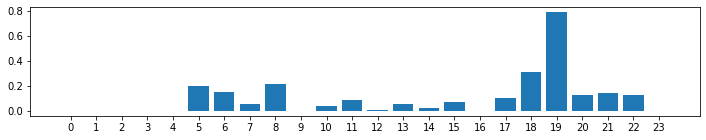

Now we compare our agent's policy with the above graph
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]]
Best time to contact customer 11


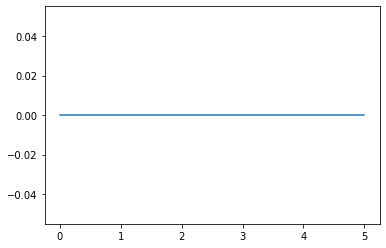

In [16]:
# Generate 10 customers from trained GMM
customers = [histogram_to_probability(cust) for cust in gmm.sample(10)[0]]
NUM_DAYS_TO_TEST = 180
randc = random.randint(1, 9)
print(randc)
# Use random RPF to create customer environment
customer = CustomerEnvironment(n_actions=1,
                               context_transition_probability=0,
                               rfps=customers[randc], reward_response=1000, reward_ignore=-100, reward_noaction=0)


agent = QLearningAgent(env=customer, eps_decay=0.9996, alpha=0.99)
rewards = []
avg_reward = []

step_counter = 0



for i in range(NUM_DAYS_TO_TEST):
    state = 0
    step_counter = step_counter + 1

    while True:
        action = agent.choose_action(state)
        state_, reward, done = customer.step(state, action)
        agent.update_Q((state, action, state_, reward))
        state = state_
        agent.decay_eps()
        if done:
            if reward > 0:
                rewards.append(1)
            else:
                rewards.append(0)
            break

    if i % 30 == 0:  
        avg_reward.append(np.mean(rewards)*100)
        #print(agent.epsilon)
        rewards = []

        
print("Let's first have a look at the customer")
plt.figure(figsize=(12, 2))
plt.xticks(ticks=range(0,24))
plt.bar(range(0,24), customer.response_probabilities)
plt.show()


plt.plot(avg_reward)
print("Now we compare our agent's policy with the above graph")
agent.print_policy()
print("Best time to contact customer", np.argmax(agent.Q[1,:]))
plt.show()




#### Notes on the above experiment
- We need to figure out how to set up the reward function in the customer model. What action/response pairs are the most valuable, and least valuable to us? What maximises the agent's score?
- We note that the agent never sends emails later in the day, since episodes are terminated early. What about slicing the day up into quarters, and then implementing a form of hierarcichal RL to first find a policy over quarters, and then move down to a specific hour within that quarter.

#### 5.3 Implementing a "quartering" system in the agent
The idea is to implement a form of hierarchical reinforcement learning to try and figure out which quarter of the day is most valuable to experiment in.

In [17]:
# Build a simple Q-learning agent
class QLearningAgentWithQuarters(QLearningAgent):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.Q = np.zeros((env.n_actions + 1, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1

        self.quarter_for_day = np.random.choice(range(4))
        self.quarters = np.zeros(4, dtype=float)
        self.average_rewards_for_day = []

    def determine_quarter(self, state):
        for i in range(4):
            if state < 6 * (i + 1):
                return i

    def choose_quarter(self):
        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            q = np.random.choice(range(4))
            self.quarter_for_day = q
            #print("exploring, choosing", q)

        else:
            # Exploit
            q = np.argmax(self.quarters)
            self.quarter = q
            #print("Exploiting, choosing", q)

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        
        #First check if we are in the active quarter
        if self.determine_quarter(state) != self.quarter_for_day:
            return 0

        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions + 1))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def update_Q(self, memory):
        (state, action, state_, reward) = memory
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

        #For quarters
        self.average_rewards_for_day.append(reward)

    def update_quarters(self):
        self.quarters[self.quarter_for_day] = self.quarters[
            self.quarter_for_day] * 0.6 + np.mean(
                self.average_rewards_for_day) * 0.4
        self.average_rewards_for_day = []


# Make quarters part of state [4x6 Value function]
# Otherwise try weighting the above update function

#Test on entire customer base.

Customer number 3
Let's first have a look at the customer


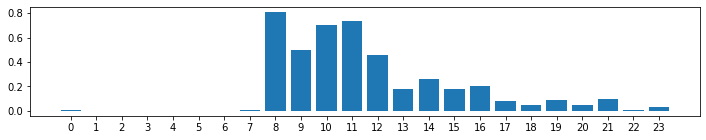

Now we compare our agent's policy with the above graph
[[ 0  0  0  0  0  0  0  0  0  1  0  0  1  0  1  0  1  1  0  0  0  0  0  0]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]]
Values for each quarter:  [-407.61141867 -192.07974729  -99.90458375 -139.28879638]
Best time to contact customer:  9
Customer type:  2
Average response rate every 30 steps


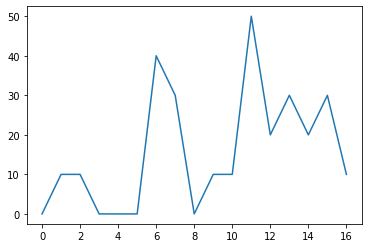

In [18]:
# Generate 10 customers from trained GMM
customers = [histogram_to_probability(cust) for cust in gmm.sample(10)[0]]
NUM_DAYS_TO_TEST = 180
randc = random.randint(1, 9)
print("Customer number",randc)
# Use random RPF to create customer environment
customer = CustomerEnvironment(n_actions=1,
                               context_transition_probability=0,
                               rfps=customers[randc], reward_response=1000, reward_ignore=-1000, reward_noaction=-100)


agent = QLearningAgentWithQuarters(env=customer, eps_decay=0.9996, alpha=0.8)
rewards = []
avg_reward = []

step_counter = 0



for i in range(NUM_DAYS_TO_TEST):
    state = 0
    step_counter = step_counter + 1
    agent.choose_quarter()
    while True:
        action = agent.choose_action(state)
        state_, reward, done = customer.step(state, action)
        agent.update_Q((state, action, state_, reward))
        state = state_
        agent.decay_eps()
        if done:
            if reward > 0:
                rewards.append(1)
            else:
                rewards.append(0)
            break
    agent.update_quarters()

    if i % 10 == 0 and i > 0:  
        avg_reward.append(np.mean(rewards)*100)
        #print(agent.epsilon)
        rewards = []

        
print("Let's first have a look at the customer")
plt.figure(figsize=(12, 2))
plt.xticks(ticks=range(0,24))
plt.bar(range(0,24), customer.response_probabilities)
plt.show()


plt.plot(avg_reward)
print("Now we compare our agent's policy with the above graph")
agent.print_policy()
print("Values for each quarter: ", agent.quarters)
print("Best time to contact customer: ", np.argmax(agent.Q[1,:]))
print("Customer type: ", np.argmax(agent.quarters))
print("Average response rate every 30 steps")
plt.show() 


#### 5.4 Testing the above agent on a larger customer base
The above agent seems to be correct most of the time, but the accuracy is not as high as I'd like it to be. Let's try testing this on a larger customer base. For the first experiment, we'll try sending emails to the customers at optimal times after training.

Training agents for 60 days...
Average response rate during training


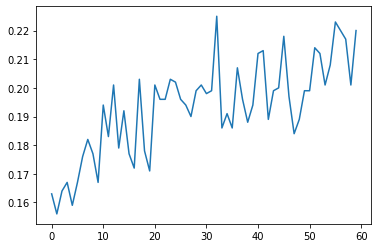


Testing customer reponses without using optimal times, sending mailer between 08:00 and 10:00...

Testing customer reponses using optimal times from trained agents...

Response rate without using optimal times: 29.948888888888884
Response rate using optimal times 59.978888888888896


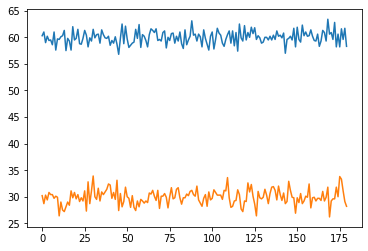

In [19]:
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
NUM_DAYS_TO_TRAIN = 60

customer_list = [
    CustomerEnvironment(n_actions=1,
                        context_transition_probability=0,
                        rfps=c,
                        reward_response=1000,
                        reward_ignore=-1000,
                        reward_noaction=-100) for c in customers
]
customer_types_list = []
rewards = np.zeros(NUM_DAYS_TO_TRAIN)

print("Training agents for " + str(NUM_DAYS_TO_TRAIN) + " days...")

for customer in customer_list:
    agent = QLearningAgentWithQuarters(env=customer,
                                       eps_decay=0.96,
                                       alpha=0.6)
   
    avg_reward = []
    step_counter = 0

    for i in range(NUM_DAYS_TO_TRAIN):
        state = 0
        step_counter = step_counter + 1
        agent.choose_quarter()
        while True:
            action = agent.choose_action(state)
            state_, reward, done = customer.step(state, action)
            agent.update_Q((state, action, state_, reward))
            state = state_
        
            if done:
                if reward > 0:
                    rewards[i] = rewards[i] + 1.0/len(customer_list)
                break
        agent.decay_eps()
        agent.update_quarters()
            
    #print("Customer type: ", np.argmax(agent.quarters))
    customer_types_list.append(np.argmax(agent.Q[1,:]))
print("Average response rate during training")
plt.plot(rewards)
plt.show()

print("\nTesting customer reponses without using optimal times, sending mailer between 08:00 and 10:00...")

NUM_DAYS_TO_TEST=180

avg_responses_u = []

for i in range(NUM_DAYS_TO_TEST):
    responses = 0
    for i in range(len(customer_list)):
        time = random.randint(7,10)
        if customer_list[i].test_single_time(time):
            responses = responses + 1
    avg_responses_u.append(responses*100/len(customers))

untrained_response_rate = np.mean(avg_responses_u)

avg_responses = []

print("\nTesting customer reponses using optimal times from trained agents...")

for i in range(NUM_DAYS_TO_TEST):
    responses = 0
    for i in range(len(customer_list)):
        time_for_first_mailer = customer_types_list[i]
        time = time_for_first_mailer
        if customer_list[i].test_single_time(time):
            responses = responses + 1
    avg_responses.append(responses*100/len(customers))

print("\nResponse rate without using optimal times:", untrained_response_rate)
print("Response rate using optimal times",np.mean(avg_responses))
plt.plot(avg_responses)
plt.plot(avg_responses_u)
plt.show()
    


We note that the response rate increases by about 100% (depending on how many days we allow the algorithm to train for) when allowing mails to be sent daily at a time when we expect the customer to have the highest probability of responding to an email. We should remember, however, that it isn't always possible for a company to send emails to each customer at a specific time. Therefore, we might still have to resort to "typed" customers, where we divide the day into 4 quarters, and attempt to determine during which quarter to emails to which type customers. This will require a slight update to the agent used above. We will now attempt building an agent of which the value function has a 4x6 shape, where the rows indicate the "quarters" in a day, and the columns indicate the 6 hours within that quarter. We will compare the output of this new agent with the output of the above agent, and test whether it can still determine the optimal time during which to communicate with the customer. In addition, we expect this new agent to also be able to determine the best "quarter" of the day for sending emails to the customer, so that we can eventually divide the customer base into different types.

#### Questions so far:
- Is a response rate vs days used to train graph useful?
- According to research, the day of the week also influences email opens. Maybe it would be a good idea to also implement this into our system? We could get a general open rate graph, and superimpose this on our customer base, based on the day of the week. What effect will this have on our state space, action space, and learning algorithm?

**Note/Idea**: Why not treat the entire customer base as the state space, where every customer is a row, and every hour is a column. In this way, we can have a value function that is representative of the entire customer base. This might mean that it could become difficult to "type" customers. We could, however, then group customers according to when their optimal times, rather than optimal quarters?

Answer to my own question: This wouldn't solve anything. We'll still have the problem of an episode terminating early. We could, however, treat the customer number as the state, simply increment the state at every step, and have 24 actions. This way, we don't have the early stop issue, which means we can remove "quartering". We can still extract the info we need for typing customers from the Q function.

#### What we need to test now:
- Larger state space as described above
- Compare to handling each customer as a "quartered" state space

#### 5.5 Building a single environment and using a single agent on the entire customer base


0.99 -68.88888888888889
0.9414801494009999 -69.41569282136895
0.8953382542587163 -68.098271155596
0.8514577710948754 -66.6916823014384
0.8097278682212583 -65.65983801810386
0.7700431458051551 -64.04001539053482
0.7323033696543974 -62.50403355921265
0.6964132180495735 -60.33342595165324
0.6622820409839835 -58.3996096608929
0.6298236312032323 -56.69058490976299
0.5989560064661611 -54.747989801921946
0.5696012024771592 -52.64868726558314
0.5416850759668536 -50.92966060009838
0.5151371174238033 -49.20442491286558
0.4898902730042049 -47.5306381180448
0.4658807751697934 -45.800763258323464
0.44304798162617254 -44.18817137918261
0.4213342221547681 -42.45144784277242
0.40068465295154065 -40.769315309374655
0.38104711810454983 -39.20200020835504
0.36237201786049694 -37.78789979205862
0.34461218334751764 -36.31285970374564
0.3277227574378037 -34.91846112262366
0.3116610814491425 -33.43564100353479
0.2963865873992079 -32.13158112240681
0.28186069554046345 -30.799269783316138
0.26804671691687404 -

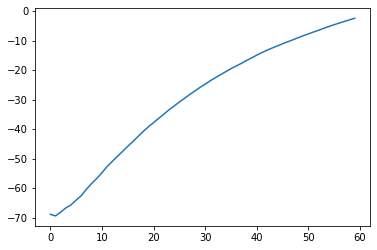

Accuracy: 0.648
Average response rate using morning mailers policy:  0.29986111111111113
Average response rate using agent policy:  0.6730222222222222


In [20]:
# Build a simple Q-learning agent
class QLearningAgentForFullCustomerBase:
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def update_Q(self, memory):
        (state, action, state_, reward) = memory
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

    def save_Q_snapshot(self):
        self.Q_history.append(self.Q)

    def decay_eps(self):
        if self.epsilon > self.eps_min:
            self.epsilon = self.eps_decay * self.epsilon

    def reset_epsilon(self):
        self.epsilon = self.eps_start

    def reset_Q(self):
        self.Q = np.zeros((self.env.n_actions, self.env.n_states), dtype=float)

    def print_policy(self):
        policy = []
        for i in range(self.env.n_states):
            policy.append(np.argmax(self.Q[:, i]))
        policy = np.array(policy)
        
        print(policy)

    def build_policy(self):
        policy = []
        for i in range(self.env.n_states):
            policy.append(np.argmax(self.Q[:, i]))
        return policy

class CustomerBaseEnvironment:
    def __init__(self, customer_response_functions, reward_response, reward_ignore):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 24
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        response_probability = self.customer_response_functions[state][action]

        reward = self.reward_ignore

        if p < response_probability:
            reward = self.reward_response

        if state == self.n_states - 1:
            done = True
        else:
            state += 1

        return state, reward, done
    
    def get_optimal_policy(self):
        l = []
        for c in self.customer_response_functions:
            l.append(np.argmax(c))
        return np.array(l)

# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseEnvironment(customers, 100, -100)

agent = QLearningAgentForFullCustomerBase(env, eps_decay=0.99, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
for i in range(300):
    state = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        state_, reward, done = env.step(state, action)
        agent.update_Q((state, action, state_, reward))
        state = state_
        avg_reward.append(reward)
    agent.decay_eps()
    if i % 5 == 0:
        print(agent.epsilon, np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

agent_policy = agent.build_policy()
opt_policy = env.get_optimal_policy()

acc = 0
for i in range(len(agent_policy)):
    if agent_policy[i] == opt_policy[i]:
        acc = acc + 1
    
print("Accuracy:", acc/len(agent_policy))

responses = 0
for i in range(180):
    for j in range(len(env.customer_response_functions)):
        p = random.uniform(0, 1)
        response = env.customer_response_functions[j][random.randint(7,10)]
        if p < response:
            responses = responses + 1
            
print("Average response rate using morning mailers policy: ", responses/(180*len(env.customer_response_functions)))

responses = 0
for i in range(180):
    for j in range(len(env.customer_response_functions)):
        p = random.uniform(0, 1)
        response = env.customer_response_functions[j][agent_policy[j]]
        if p < response:
            responses = responses + 1
            
print("Average response rate using agent policy: ", responses/(180*len(env.customer_response_functions)))

**Comments**

After running the above expirement multiple times, with different parameter sets, we notice that the response rate is once again increased significantly. This process is faster to train, altough that doesn't really matter in this case. We see that the agent can still significantly increase its score if more training time is provided. We also notice that the agent's accuracy compared to the objective optimal policy is fairly low, but that does not mean that the agent has not found a solution to the problem, although it might not be the optimal one.

#### 5.6 But what happens if we let the agent run continuously? 
This will eliminate the need for discrete exploration/exploitation periods.

Running expirement...
Agent epsilon and mean reward log:
0.99 -70.5050505050505
0.5989560064661611 -55.52461266915081
0.36237201786049694 -38.23942964649965
0.21923726936647234 -24.75528180674217
0.13263987810938213 -14.903229016368973
0.08024793100055952 -7.224989043388183
0.0485504851305729 -1.093059570085385
0.029373338066467324 3.5892760477506482
0.017771047742294682 7.211651163370657
0.010751591703479106 10.160313975919644
0.006504778211990459 12.581089442903052
0.003935430283638283 14.7276720085664
0.0023809591983979563 16.644536514750662
0.0014404947606376892 18.32685601929369
0.000993147795920851 19.65562989486298
0.000993147795920851 20.729703458101973
0.000993147795920851 21.714628147667263
0.000993147795920851 22.624002632228347
0.000993147795920851 23.446431147959466
0.000993147795920851 24.208877064953363

Average reward every 10 steps


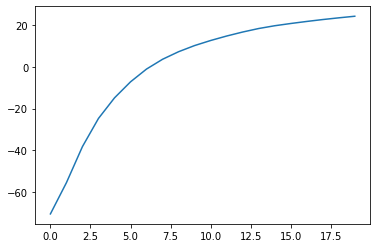


Average response rate


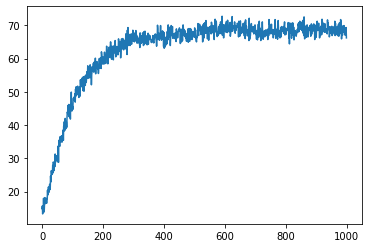

In [21]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseEnvironment(customers, 100, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = QLearningAgentForFullCustomerBase(env, eps_decay=0.99, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []
for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done = env.step(state, action)
        agent.update_Q((state, action, state_, reward))
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    agent.decay_eps()
    response_rate.append(responses*100/1000)
    if i % 50 == 0:
        print(agent.epsilon, np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()

agent_policy = agent.build_policy()
opt_policy = env.get_optimal_policy()

**Comments**

We see that the agent eventually finds the optimal solution. This happens within about 1 year. We do note, however, that this is only valid for a static customer base, where no customers are ever gained or lost, and customer behaviour is stationary.

- Not updating at every single step? (Gamma may already be controlling this)
- Opt out vs inactive (flag)

#### 5.7 Building a more complex customer model
***
**5.7.1** Allowing opt-in/out

The first step we'll take towards creating a more complex and realistic customer base would be to allow customers to opt in or out of receiving communication from the company. This will be done using a very low probability, against which a random variable between [0,1] will be compared, and the environment will then opt out/in that customer. An opted out customer can not longer respond to any emails, but can opt back in. Opt-in will also be controlled by a small probability.

We also want the agent to have the ability not to send communications to a certain customer, especially if the agent could figure out that this customer has opted out. We will therefore add an additional action to our action space, which will mean not sending anything to the customer, and the reward for not sending anything will just be 0.

In addition, we will assume that the agent could be notified when a customer opts in or out, and that the agent can just decide not to contact that customer in the event that this happens.

**TODO**

Research is required to determine the average drop off /sign up rates of customers in ecommerce companies, so that we can adjust our opt in/out probabilities accordingly.

**NOTE:** As per the company's data, the opt-out rate is 0.03%. Research might still be required to determine the chances of an opted-out customer opting back in.


In [22]:
class CustomerBaseEnvironmentWithOpt(CustomerBaseEnvironment):
    def __init__(self,
                 customer_response_functions,
                 reward_response,
                 reward_ignore,
                 opt_out_prob=0.0003,
                 opt_in_prob=0.001):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 25
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.opt_out = np.zeros(self.n_states)
        self.opt_out_prob = opt_out_prob
        self.opt_in_prob = opt_in_prob

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        reward = 0

        # We check that communication is being sent to this customer
        if action != 24:
            response_probability = self.customer_response_functions[state][
                action]
            reward = self.reward_ignore
            # We also check that the customer is opted in
            if p < response_probability and self.opt_out[state] == 0:
                reward = self.reward_response
        #Random opt out
        if random.uniform(0, 1) < self.opt_out_prob:
            self.opt_out[state] = 1
        #Allow random opt in
        if random.uniform(0,
                          1) < self.opt_in_prob and self.opt_out[state] == 1:
            #print("Opted back in!")
            self.opt_out[state] = 0
        if state == self.n_states - 1:
            done = True
        else:
            state += 1
        # Also return the opt-in status of this customer
        return state, reward, done, self.opt_out[state - 1]

In [23]:
class QLearningAgentForFullCustomerBaseWithOpting(QLearningAgentForFullCustomerBase):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
    
    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out
        
        if(self.opt_out[state] == 1):
            return env.n_actions - 1
        
        # Otherwise continue normally
        
        epsilon = max(self.epsilon, self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def update_Q(self, memory):
        (state, action, state_, reward, customer_opted_out) = memory
        self.opt_out[state] = customer_opted_out
        #if customer_opted_out == 1:
        #    return
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

Running expirement...
Agent epsilon and mean reward log:

0.992 -5.7894736842105265
Number of customers opted in: 1000.0
Opt outs according to agent 0

0.6638887049639195 26.07458292443572
Number of customers opted in: 980.0
Opt outs according to agent 26

0.44430263364785333 71.11441307578009
Number of customers opted in: 961.0
Opt outs according to agent 24

0.2973462702263431 105.64160317986088
Number of customers opted in: 943.0
Opt outs according to agent 25

0.1989968047040511 132.22692211993032
Number of customers opted in: 927.0
Opt outs according to agent 22

0.13317714815214776 153.35126519226938
Number of customers opted in: 921.0
Opt outs according to agent 21

0.08912782703378778 170.1717893337764
Number of customers opted in: 913.0
Opt outs according to agent 25

0.05964814280817498 183.45690269269127
Number of customers opted in: 908.0
Opt outs according to agent 30

0.03991908092986112 194.0446439705699
Number of customers opted in: 897.0
Opt outs according to agent 31


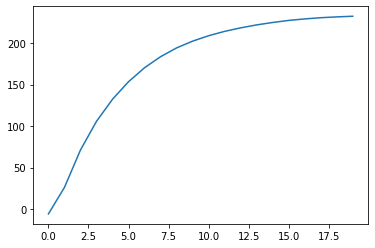


Average response rate


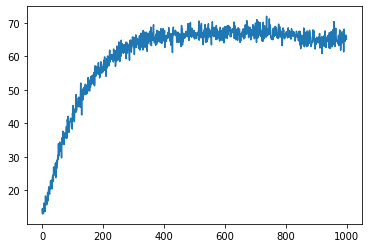

In [24]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseEnvironmentWithOpt(customers, 500, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = QLearningAgentForFullCustomerBaseWithOpting(env, eps_decay=0.992, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []
for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out))
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    agent.decay_eps()
    # Only calculate the response rate of opted-in customers
    response_rate.append(responses * 100 / (1000 - np.sum(env.opt_out)))
    if i % 50 == 0:
        print()
        print(agent.epsilon, np.mean(avg_reward[:-50]))
        scores.append(np.mean(avg_reward[:-50]))
        print("Number of customers opted in:", 1000 - np.sum(env.opt_out))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()

**Comments**
We see that our average response rate during the "control" phase is lower now that we've enabled the agent to also do nothing. This could be because customers are able to opt back in over time, but the agent just doesn't know what to do then. It should be possible to have a system that keeps a separate epsilon for all customers, which we then bump if we detect a change in that specific customer's opted status. 

**Just a thought**

The agent is created as such that it has a set number of states and actions to train on. Therefore, we need to assume that we'll have to limit the size of the customer base. 

We could potentially just have an upper limit, and set the environment up in such a way that all non-existent customers are flagged as "opted out". Then, as we gain more customers, these flags could be manually set as "opted in", and the agent can start experimenting with these customers. 

This will probably mean that we will need a separate epsilon value for each customer, which the agent can individually control, especially during the "control" phase.

***
We can use the same opted-in/out array in the agent to detect and keep track of customers that become inactive. We'll probably have to assume that when a customer becomes inactive, that they'll stay that way. We could potentially have the agent check in on customers.

#### 5.7.2 Building an agent that keeps track of each customer's "epsilon" value individually

In [25]:
class QLA_EPSILON_TRACKING(QLearningAgentForFullCustomerBaseWithOpting):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        #self.Q = np.random.rand(env.n_actions, env.n_states)
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
        self.epsilon_array = self.eps_start * np.ones(env.n_states)

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out

        if (self.opt_out[state] == 1):
            return env.n_actions - 1

        # Otherwise continue normally

        epsilon = max(self.epsilon_array[state], self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def decay_eps(self, state):
        if self.epsilon_array[state] > self.eps_min:
            self.epsilon_array[
                state] = self.eps_decay * self.epsilon_array[state_]

    def update_Q(self, memory):
        
        (state, action, state_, reward, customer_opted_out) = memory
        
        if self.opt_out[state] != customer_opted_out:
            #Bump up epsilon for customer when the customer opts back in
            if customer_opted_out == 0:
                customer_eps = self.epsilon_array[state]
                self.epsilon_array[state] = np.minimum(customer_eps + 0.1, 0.01) #arbitrary bump, should test, also should not go above 1.0
                
            self.opt_out[state] = customer_opted_out
        
        if customer_opted_out == 1:
            return
        
        error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action, state]
        '''
        Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
        '''
        self.Q[action, state] = self.Q[action, state] + \
            self.alpha * (reward + error)

Running expirement...
Agent epsilon and mean reward log:

1.0 -16.333333333333332
Number of customers opted in: 999.0
Opt outs according to agent 0

1.0 62.57185332011893
Number of customers opted in: 977.0
Opt outs according to agent 10

1.0 123.93130910900946
Number of customers opted in: 944.0
Opt outs according to agent 6

1.0 162.77799933532737
Number of customers opted in: 924.0
Opt outs according to agent 7

1.0 187.71264654527315
Number of customers opted in: 904.0
Opt outs according to agent 15

1.0 204.75184667598322
Number of customers opted in: 886.0
Opt outs according to agent 15

1.0 216.49026460309537
Number of customers opted in: 873.0
Opt outs according to agent 14

1.0 224.3996290483664
Number of customers opted in: 852.0
Opt outs according to agent 25

1.0 229.7630166063179
Number of customers opted in: 837.0
Opt outs according to agent 30

1.0 233.2767232767233
Number of customers opted in: 826.0
Opt outs according to agent 40

Average reward every 10 steps


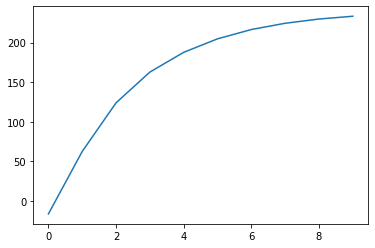


Average response rate


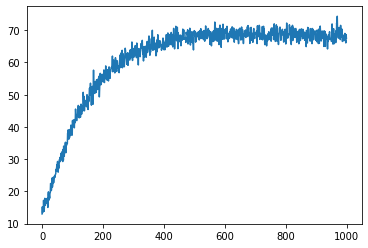

In [26]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseEnvironmentWithOpt(customers, 500, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = QLA_EPSILON_TRACKING(env, eps_decay=0.993, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []

for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out))
        agent.decay_eps(state)
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    
    # Only calculate the response rate of opted-in customers
    response_rate.append(responses * 100 / (1000 - np.sum(env.opt_out)))
    if i % 100 == 0:
        print()
        print(agent.epsilon, np.mean(avg_reward[:-100]))
        scores.append(np.mean(avg_reward[:-100]))
        print("Number of customers opted in:", 1000 - np.sum(env.opt_out))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()

**Comments**

By having a separate **$\epsilon$** value for each customer, we see an improved average response rate over time. We do note, however, that this is still not as high as for a stationary environment with no "do nothing" action. The above agent/customer combination also allows a customers to opt-in after being opted out previously. When this happens, we bump that customer's epsilon value, since we don't necessarily know that they will still behave the same as before opting out. For now, a low epsilon bump yields the best results, but this is because our customer model does not yet support customers changing behaviour.

#### 5.7.3 Allowing customers to become active/inactive without notifying the agent

Some research will definitely also be required to determine the active/inactive probabilities

In [27]:
class CustomerBaseEnvironmentWithInactive(CustomerBaseEnvironmentWithOpt):
    def __init__(self,
                 customer_response_functions,
                 reward_response,
                 reward_ignore,
                 opt_out_prob=0.0003,
                 opt_in_prob=0.001, prob_inactive=0.0001, prop_active=0.0001):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 25
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.opt_out = np.zeros(self.n_states, dtype=int)
        self.opt_out_prob = opt_out_prob
        self.opt_in_prob = opt_in_prob
        self.prob_inactive = prob_inactive
        self.prop_active = prop_active
        self.inactive = np.zeros(self.n_states, dtype=int)

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        reward = 0

        # We check that communication is being sent to this customer
        if action != 24:
            response_probability = self.customer_response_functions[state][
                action]
            reward = self.reward_ignore
            # We also check that the customer is active
            if p < response_probability and self.inactive[state] == 0:
                reward = self.reward_response
            
        # Only active customers can opt in/out
        if self.inactive[state] == 0:
            #Random opt out
            if random.uniform(0, 1) < self.opt_out_prob:
                self.opt_out[state] = 1
            #Allow random opt in
            if random.uniform(0, 1) < self.opt_in_prob and self.opt_out[state] == 1:
                self.opt_out[state] = 0
                self.inactive[state] = 0
        
        # Only opted in customers can become active/inactive
        if self.opt_out[state] == 0:
            if random.uniform(0,1) < self.prob_inactive:
                self.inactive[state] = 1
            if random.uniform(0,1) < self.prop_active:
                self.inactive[state] = 0
                
        if state == self.n_states - 1:
            done = True
        else:
            state += 1
        # Also return the opt-in status of this customer
        return state, reward, done, self.opt_out[state - 1]

Running expirement...
Agent epsilon and mean reward log:

Average reward every 10 steps


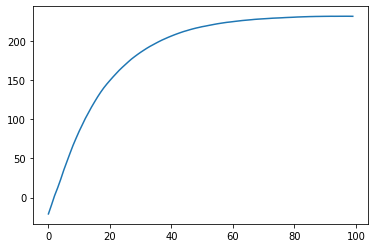


Average response rate


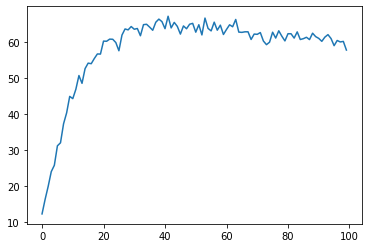

Response rate at 60 days: 32.04868154158215


In [28]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseEnvironmentWithInactive(customers, 500, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = QLA_EPSILON_TRACKING(env, eps_decay=0.990, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []

for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out))
        agent.decay_eps(state)
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    
    # Only calculate the response rate of opted-in customers
    # this does not take into account inactive customers
    
    if i % 10 == 0:
        response_rate.append(responses * 100 / (1000 - np.sum(env.opt_out)))
        #print()
        #print("Mean reward:",np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))
        #print("Number of customers opted out:", np.sum(env.opt_out))
        #print("Number of inactive customers:",np.sum(env.inactive))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        #print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()

print("Response rate at 60 days:", response_rate[6])

**An idea:** Why not try and initialise the policy somewhat smarter?

Running expirement...
Agent epsilon and mean reward log:

Average reward every 10 steps


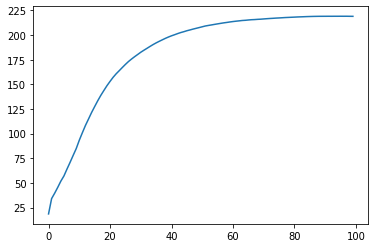


Average response rate


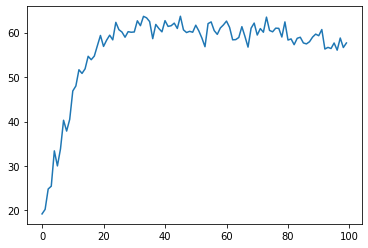

Response rate at 60 days: 33.84146341463415


In [29]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseEnvironmentWithInactive(customers, 500, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = QLA_EPSILON_TRACKING(env, eps_start=0.7,eps_decay=0.990, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []

# Let's try and initiate a standard policy with the agent, see if that makes a difference
agent.Q[7:14,:] = 1000

for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out))
        agent.decay_eps(state)
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    
    # Only calculate the response rate of opted-in customers
    # this does not take into account inactive customers
    
    if i % 10 == 0:
        response_rate.append(responses * 100 / (1000 - np.sum(env.opt_out)))
        #print()
        #print("Mean reward:",np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))
        #print("Number of customers opted out:", np.sum(env.opt_out))
        #print("Number of inactive customers:",np.sum(env.inactive))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        #print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()


print("Response rate at 60 days:", response_rate[6])

**Comments**

We see worse performance here, initialising a "standard" policy does not seem to help. Interestingly, initialising a poliy and then reducing the agent's initial epsilon value seems to make a difference. Lower response rate during the control phase, but a better average response rate at 30 days. Should be interesting to see what happens if we **initialise the policy with a reasonable starting policy from actual customer data**.

#### 5.7.4 But what happens if we change the agent to use RUQL?

In [30]:
class RUQLA_EPSILON_TRACKING(QLearningAgentForFullCustomerBaseWithOpting):
    def __init__(self,
                 env,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        #self.Q = np.random.rand(env.n_actions, env.n_states)
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
        self.epsilon_array = self.eps_start * np.ones(env.n_states)

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out

        if (self.opt_out[state] == 1):
            return env.n_actions - 1

        # Otherwise continue normally

        epsilon = max(self.epsilon_array[state], self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def decay_eps(self, state):
        if self.epsilon_array[state] > self.eps_min:
            self.epsilon_array[
                state] = self.eps_decay * self.epsilon_array[state_]

    def update_Q(self, memory):
        
        (state, action, state_, reward, customer_opted_out) = memory
        
        if self.opt_out[state] != customer_opted_out:
            #Bump up epsilon for customer when the customer opts back in
            if customer_opted_out == 0:
                customer_eps = self.epsilon_array[state]
                self.epsilon_array[state] = np.minimum(customer_eps + 0.4, 0.4) #arbitrary bump, should test, also should not go above 1.0
                
            self.opt_out[state] = customer_opted_out
        
        if customer_opted_out == 1:
            return
        
        error = self.gamma * \
            np.max(self.Q[:, state_]) - \
            self.Q[action, state]

        pi_sa = np.max(self.Q[:, state])
        if pi_sa != 0 and int(1/pi_sa) != 0:
            '''
            if int(1/pi_sa) > 1:
                print(int(1/pi_sa))
            '''
            for _ in range(int(1/pi_sa)):
                self.Q[action, state] = self.Q[action, state] + \
                    self.alpha * (reward + error)
        else:
            self.Q[action, state] = self.Q[action, state] + \
                self.alpha * (reward + error)
        

Running expirement...
Agent epsilon and mean reward log:

Average reward every 10 steps


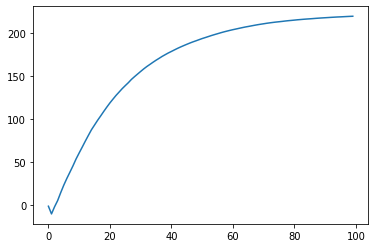


Average response rate


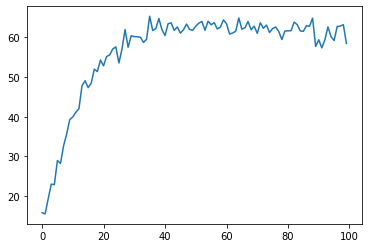

Response rate at 60 days: 28.234086242299796


In [31]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseEnvironmentWithInactive(customers, 500, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = RUQLA_EPSILON_TRACKING(env, eps_start=1.0,eps_decay=0.993, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []

# Let's try and initiate a standard policy with the agent, see if that makes a difference
#agent.Q[7:11,:] = 1000

for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out))
        agent.decay_eps(state)
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    
    # Only calculate the response rate of opted-in customers
    # this does not take into account inactive customers
    
    if i % 10 == 0:
        response_rate.append(responses * 100 / (1000 - np.sum(env.opt_out)))
        #print()
        #print("Mean reward:",np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))
        #print("Number of customers opted out:", np.sum(env.opt_out))
        #print("Number of inactive customers:",np.sum(env.inactive))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        #print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()


print("Response rate at 60 days:", response_rate[6])

**Comments**

What about building an agent that dynamically switches between normal Q learning updates and RUQL? The idea here would be to allow normal Q learning updates during the early training stages, and then leave the control phase up to RUQL, as it's supposedly better at handling non-stationary environments.

In [32]:
class SWITCHING_AGENT(QLearningAgentForFullCustomerBaseWithOpting):
    def __init__(self,
                 env,
                 days_until_switch,
                 eps_start=1.0,
                 eps_decay=0.096,
                 eps_min=0.001,
                 gamma=0.99,
                 alpha=0.99):
        self.env = env
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.alpha = alpha
        #self.Q = np.random.rand(env.n_actions, env.n_states)
        self.Q = np.zeros((env.n_actions, env.n_states), dtype=float)
        self.Q_history = []
        self.reward_buffer = []
        self.mse_buffer = []
        self.iteration_cntr = 1
        self.opt_out = np.zeros(env.n_states)
        self.epsilon_array = self.eps_start * np.ones(env.n_states)
        self.days_until_switch = days_until_switch

    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''
        # Do nothing if a customer is opted out

        if (self.opt_out[state] == 1):
            return env.n_actions - 1

        # Otherwise continue normally

        epsilon = max(self.epsilon_array[state], self.eps_min)

        if random.uniform(0, 1) < epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            actions = self.Q[:, state]

            return np.argmax(actions)

    def decay_eps(self, state):
        if self.epsilon_array[state] > self.eps_min:
            self.epsilon_array[
                state] = self.eps_decay * self.epsilon_array[state_]

    def update_Q(self, memory):

        (state, action, state_, reward, customer_opted_out, episode) = memory

        if self.opt_out[state] != customer_opted_out:
            #Bump up epsilon for customer when the customer opts back in
            if customer_opted_out == 0:
                customer_eps = self.epsilon_array[state]
                self.epsilon_array[state] = np.minimum(
                    customer_eps + 0.4, 0.4
                )  #arbitrary bump, should test, also should not go above 1.0

            self.opt_out[state] = customer_opted_out

        if customer_opted_out == 1:
            return

        if episode > self.days_until_switch:

            error = self.gamma * \
                np.max(self.Q[:, state_]) - \
            self.Q[action, state]

            pi_sa = np.max(self.Q[:, state])
            if pi_sa != 0 and int(1 / pi_sa) != 0:
                '''
                if int(1/pi_sa) > 1:
                print(int(1/pi_sa))
                '''
                for _ in range(int(1 / pi_sa)):
                    self.Q[action, state] = self.Q[action, state] + \
                        self.alpha * (reward + error)
            else:
                self.Q[action, state] = self.Q[action, state] + \
                    self.alpha * (reward + error)
        else:
            error = self.gamma * np.max(self.Q[:, state_]) - self.Q[action,
                                                                    state]
            '''
            Based on the Q-learning update function on https://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html
            '''
            self.Q[action, state] = self.Q[action, state] + \
                self.alpha * (reward + error)

Running expirement...
Agent epsilon and mean reward log:

Average reward every 10 steps


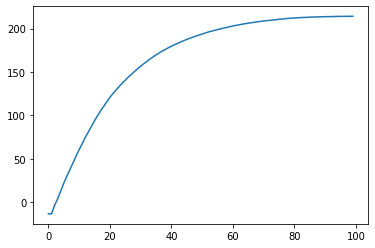


Average response rate


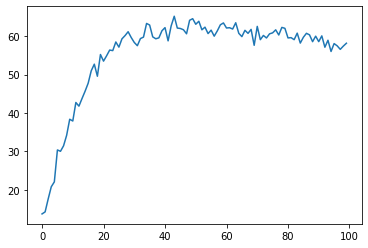

Response rate at 60 days: 30.020491803278688


In [33]:
# EXPERIMENT
NUM_CUSTOMERS = 1000
customers = [histogram_to_probability(cust) for cust in gmm.sample(NUM_CUSTOMERS)[0]]
env = CustomerBaseEnvironmentWithInactive(customers, 500, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = SWITCHING_AGENT(env, days_until_switch=100, eps_start=1.0, eps_decay=0.993, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []

# Let's try and initiate a standard policy with the agent, see if that makes a difference
#agent.Q[5:14,:] = 1000

for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out, i))
        agent.decay_eps(state)
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    
    # Only calculate the response rate of opted-in customers
    # this does not take into account inactive customers
    
    if i % 10 == 0:
        response_rate.append(responses * 100 / (NUM_CUSTOMERS - np.sum(env.opt_out)))
        #print()
        #print("Mean reward:",np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))
        #print("Number of customers opted out:", np.sum(env.opt_out))
        #print("Number of inactive customers:",np.sum(env.inactive))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        #print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()


print("Response rate at 60 days:", response_rate[6])

#### 5.7.5 Testing the above agent on a dormant customer base


Running expirement...
Agent epsilon and mean reward log:

Average reward every 10 steps


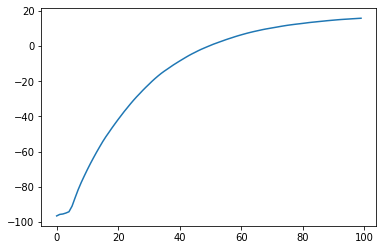


Average response rate


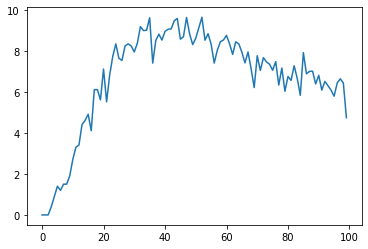

Response rate at 60 days: 1.2012012012012012


In [34]:
class CustomerBaseEnvironmentWithAllInactive(CustomerBaseEnvironmentWithOpt):
    def __init__(self,
                 customer_response_functions,
                 reward_response,
                 reward_ignore,
                 opt_out_prob=0.0003,
                 opt_in_prob=0.001, prob_inactive=0.0005, prop_active=0.0007):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 25
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.opt_out = np.zeros(self.n_states, dtype=int)
        self.opt_out_prob = opt_out_prob
        self.opt_in_prob = opt_in_prob
        self.prob_inactive = prob_inactive
        self.prop_active = prop_active
        self.inactive = np.ones(self.n_states, dtype=int)
        
    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        reward = 0

        # We check that communication is being sent to this customer
        if action != 24:
            response_probability = self.customer_response_functions[state][
                action]
            reward = self.reward_ignore
            # We also check that the customer is active
            if p < response_probability and self.inactive[state] == 0:
                reward = self.reward_response
            
        # Only active customers can opt in/out
        if self.inactive[state] == 0:
            #Random opt out
            if random.uniform(0, 1) < self.opt_out_prob:
                self.opt_out[state] = 1
            #Allow random opt in
            if random.uniform(0, 1) < self.opt_in_prob and self.opt_out[state] == 1:
                self.opt_out[state] = 0
                self.inactive[state] = 0
        
        # Only opted in customers can become active/inactive
        if self.opt_out[state] == 0:
            if random.uniform(0,1) < self.prob_inactive:
                self.inactive[state] = 1
            if random.uniform(0,1) < self.prop_active:
                self.inactive[state] = 0
                
        if state == self.n_states - 1:
            done = True
        else:
            state += 1
        # Also return the opt-in status of this customer
        return state, reward, done, self.opt_out[state - 1]
        
# EXPERIMENT
NUM_CUSTOMERS = 1000
customers = [histogram_to_probability(cust) for cust in gmm.sample(NUM_CUSTOMERS)[0]]
env = CustomerBaseEnvironmentWithAllInactive(customers, 500, -100)

print("Running expirement...")
print("Agent epsilon and mean reward log:")
agent = QLA_EPSILON_TRACKING(env, eps_start=1.0, eps_decay=0.993, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []

# Let's try and initiate a standard policy with the agent, see if that makes a difference
#agent.Q[5:14,:] = 1000

for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out))
        agent.decay_eps(state)
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    
    # Only calculate the response rate of opted-in customers
    # this does not take into account inactive customers
    
    if i % 10 == 0:
        response_rate.append(responses * 100 / (NUM_CUSTOMERS - np.sum(env.opt_out)))
        #print()
        #print("Mean reward:",np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))
        #print("Number of customers opted out:", np.sum(env.opt_out))
        #print("Number of inactive customers:",np.sum(env.inactive))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        #print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nAverage response rate")
plt.plot(response_rate)
plt.show()


print("Response rate at 60 days:", response_rate[6])

In [35]:
class CustomerBaseFinalForm(CustomerBaseEnvironmentWithInactive):
    def __init__(self,
                 customer_response_functions,
                 reward_response,
                 reward_ignore,
                 opt_out_prob=0.0003,
                 opt_in_prob=0.001, prob_inactive=0.0001, prop_active=0.0001, ctp=0.0001):
        self.customer_response_functions = np.stack(
            customer_response_functions, axis=0)
        self.n_actions = 25
        self.n_states = len(customer_response_functions)
        self.reward_response = reward_response
        self.reward_ignore = reward_ignore
        self.opt_out = np.zeros(self.n_states, dtype=int)
        self.opt_out_prob = opt_out_prob
        self.opt_in_prob = opt_in_prob
        self.prob_inactive = prob_inactive
        self.prop_active = prop_active
        self.inactive = np.zeros(self.n_states, dtype=int)
        self.ctp = ctp
        self.num_transitions = 0
    
    def reset(self):
        return 0

    def step(self, state, action):
        done = False

        p = random.uniform(0, 1)

        reward = 0

        # We check that communication is being sent to this customer
        if action != 24:
            response_probability = self.customer_response_functions[state][
                action]
            reward = self.reward_ignore
            # We also check that the customer is active
            if p < response_probability and self.inactive[state] == 0:
                reward = self.reward_response
            
        # Only active customers can opt in/out
        if self.inactive[state] == 0:
            #Random opt out
            if random.uniform(0, 1) < self.opt_out_prob:
                self.opt_out[state] = 1
            #Allow random opt in
            if random.uniform(0, 1) < self.opt_in_prob and self.opt_out[state] == 1:
                self.opt_out[state] = 0
                self.inactive[state] = 0
        
        # Only opted in customers can become active/inactive
        if self.opt_out[state] == 0:
            if random.uniform(0,1) < self.prob_inactive:
                self.inactive[state] = 1
            if random.uniform(0,1) < self.prop_active:
                self.inactive[state] = 0
        
        self.change_context(state)
                
        if state == self.n_states - 1:
            done = True
        else:
            state += 1
        # Also return the opt-in status of this customer

        return state, reward, done, self.opt_out[state - 1]

    def clip_rp_function(self, y, max_probability=0.8, epsilon=0.05):
        # Clip function
        for i in range(len(y)):
            if y[i] < epsilon:
                y[i] = epsilon

            if y[i] > max_probability:
                y[i] = max_probability
        return y

    def alter_function(self, y, severity, probability=0.2):
        for i in range(len(y)):
            if random.uniform(0, 1) < probability:
                if random.uniform(0, 1) > 0.5:
                    y[i] = y[i] + random.uniform(0, severity)
                else:
                    y[i] = y[i] - random.uniform(0, severity)
        return self.clip_rp_function(y)

    def change_context(self, state):
        if random.uniform(0, 1) < self.ctp:
            self.customer_response_functions[state] = self.alter_function(self.customer_response_functions[state], severity=0.3, probability=0.2)
            self.num_transitions = self.num_transitions + 1

Running expirement...

Average reward every 10 steps


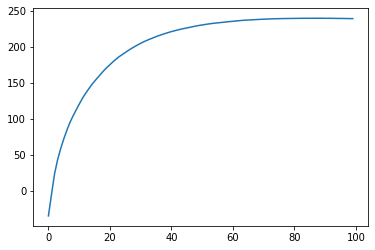


Number of context transitions in customer base 103

Average response rate


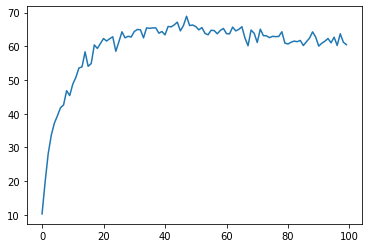

Response rate at 60 days: 41.76829268292683


In [36]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
env = CustomerBaseFinalForm(customers, 500, -100)

print("Running expirement...")
agent = QLA_EPSILON_TRACKING(env, eps_start=0.7,eps_decay=0.990, alpha=0.3, gamma=0.5)
avg_reward = []
scores = []
response_rate = []

# Let's try and initiate a standard policy with the agent, see if that makes a difference
#agent.Q[7:14,:] = 1000

for i in range(1000):
    state = 0
    done = False
    responses = 0
    while not done:
        action = agent.choose_action(state)
        state_, reward, done, customer_opted_out = env.step(state, action)
        agent.update_Q((state, action, state_, reward, customer_opted_out))
        agent.decay_eps(state)
        state = state_
        avg_reward.append(reward)
        if reward > 0:
            responses = responses + 1
    
    # Only calculate the response rate of opted-in customers
    # this does not take into account inactive customers
    
    if i % 10 == 0:
        response_rate.append(responses * 100 / (1000 - np.sum(env.opt_out)))
        #print()
        #print("Mean reward:",np.mean(avg_reward[:-10]))
        scores.append(np.mean(avg_reward[:-10]))
        #print("Number of customers opted out:", np.sum(env.opt_out))
        #print("Number of inactive customers:",np.sum(env.inactive))
        policy = agent.build_policy()
        opt_outs = 0
        for value in policy:
            if value == 24:
                opt_outs = opt_outs + 1
        #print("Opt outs according to agent", opt_outs)

print("\nAverage reward every 10 steps")
plt.plot(scores)
plt.show()

print("\nNumber of context transitions in customer base", env.num_transitions)
print("\nAverage response rate")
plt.plot(response_rate)
plt.show()


print("Response rate at 60 days:", response_rate[6])

#### 5.8 Summarising all the above experiments

In [37]:
class Experiment:
    def __init__(self, agent, customers, days_to_run, initialise_policy,
                 switching_agent, epsilon_tracking = True):
        self.agent = agent
        self.days_to_run = days_to_run
        self.initialise_policy = initialise_policy
        self.switching_agent = switching_agent
        self.epsilon_tracking = epsilon_tracking
        
        # Return values
        self.scores = []
        self.num_transitions = 0
        self.response_rate = []
        self.response_rate_60_days = 0
    
        self.env = CustomerBaseFinalForm(customers, 500, -100, ctp=0.01)

    def run(self):

        print("Running expirement...")

        avg_reward = []
        scores = []
        response_rate = []

        if self.initialise_policy:
            agent.Q[7:14, :] = 300

        for i in range(self.days_to_run):
            state = 0
            done = False
            responses = 0
            while not done:
                action = self.agent.choose_action(state)
                state_, reward, done, customer_opted_out = self.env.step(
                    state, action)
                if self.switching_agent:
                    self.agent.update_Q(
                        (state, action, state_, reward, customer_opted_out, i))
                else:
                    self.agent.update_Q(
                        (state, action, state_, reward, customer_opted_out))
                if self.epsilon_tracking:
                    self.agent.decay_eps(state)
                else:
                    self.agent.decay_eps()
                state = state_
                avg_reward.append(reward)
                if reward > 0:
                    responses = responses + 1

            # Only calculate the response rate of opted-in customers
            # this does not take into account inactive customers

            if i % 10 == 0:
                response_rate.append(responses * 100 /
                                     (1000 - np.sum(env.opt_out)))
                scores.append(np.mean(avg_reward[:-10]))
                policy = agent.build_policy()
                opt_outs = 0
                for value in policy:
                    if value == 24:
                        opt_outs = opt_outs + 1

 
        self.scores = scores
        self.num_transitions = self.env.num_transitions
        self.response_rate = response_rate
        self.response_rate_60_days = response_rate[6]
    

In [38]:
# EXPERIMENT
customers = [histogram_to_probability(cust) for cust in gmm.sample(1000)[0]]
agent_1 = QLearningAgentForFullCustomerBaseWithOpting(env,
                                                      eps_start=0.7,
                                                      eps_decay=0.990,
                                                      alpha=0.3,
                                                      gamma=0.5)
agent_2 = QLA_EPSILON_TRACKING(env,
                               eps_start=0.7,
                               eps_decay=0.990,
                               alpha=0.3,
                               gamma=0.5)
agent_3 = RUQLA_EPSILON_TRACKING(env,
                                 eps_start=0.7,
                                 eps_decay=0.990,
                                 alpha=0.3,
                                 gamma=0.5)
agent_4 = SWITCHING_AGENT(env,
                          days_until_switch=100,
                          eps_start=0.7,
                          eps_decay=0.990,
                          alpha=0.3,
                          gamma=0.5)

# 1. No policy initialisation
# Normal Q-learning
exp_1 = Experiment(agent_1,
                   customers,
                   1500,
                   False,
                   False,
                   epsilon_tracking=False)
# Individual epsilon tracking
exp_2 = Experiment(agent_2, customers, 1500, False, False)
# RUQL with individual epsilon tracking
exp_3 = Experiment(agent_3, customers, 1500, False, False)
# Individual epsilon tracking, switches between QL and RUQL
#exp_4_mem = Experiment(agent_4, env, 100, False, True)

# 2. With policy initialisation
# Normal Q-learning
exp_5 = Experiment(agent_1,
                   customers,
                   1500,
                   True,
                   False,
                   epsilon_tracking=False)
# Individual epsilon tracking
exp_6 = Experiment(agent_2, customers, 1500, True, False)
# RUQL with individual epsilon tracking
exp_7 = Experiment(agent_3, customers, 1500, True, False)

exp_1.run()
exp_2.run()
exp_3.run()
exp_5.run()
exp_6.run()
exp_7.run()

print("Done")

Running expirement...
Running expirement...
Running expirement...
Running expirement...
Running expirement...
Running expirement...
Done


Average response rate over time


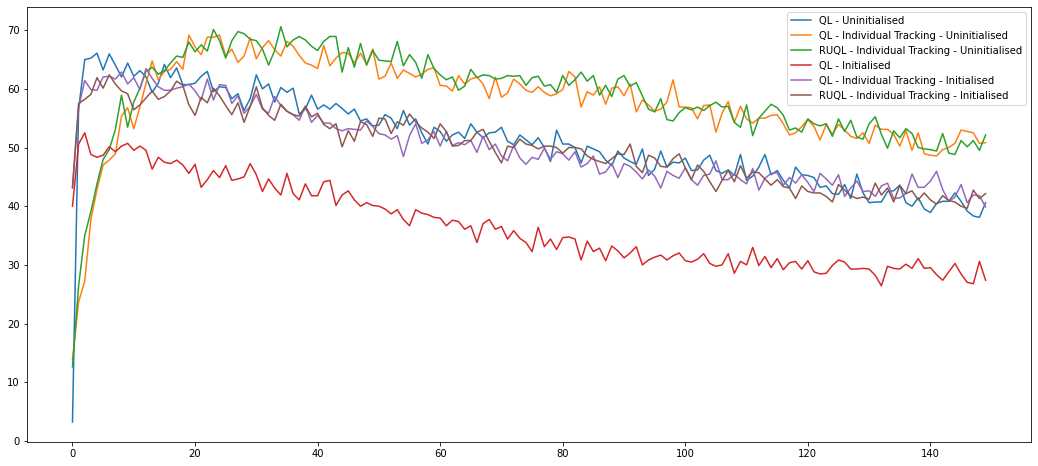

Average reward over time


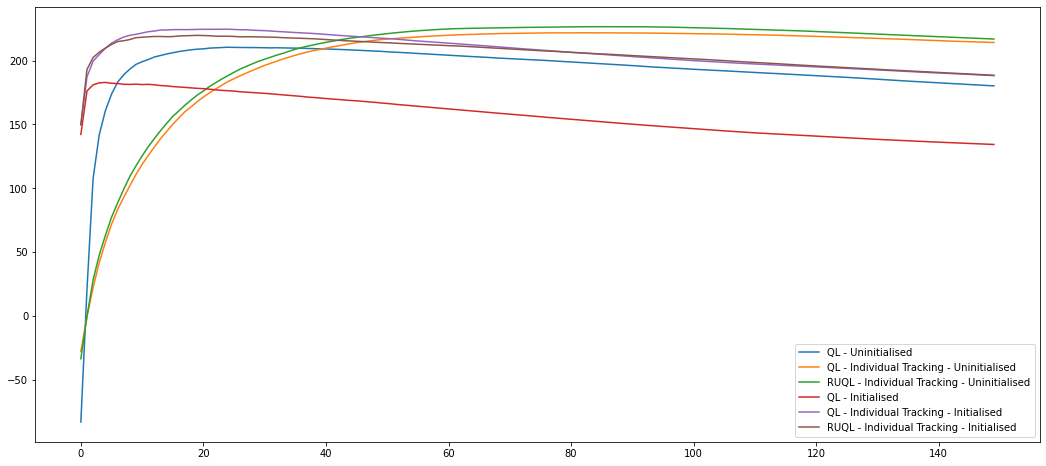


Response rate at 60 days for each experiment:
QL - Uninitialised: 65.95238095238095
QL - Individual Tracking - Uninitialised: 47.857142857142854
RUQL - Individual Tracking - Uninitialised: 49.642857142857146
QL - Initialised: 50.11904761904762
QL - Individual Tracking - Initialised: 62.142857142857146
RUQL - Individual Tracking - Initialised: 62.38095238095238

Number of context transitions in each experiment
QL - Uninitialised: 15152
QL - Individual Tracking - Uninitialised: 14794
RUQL - Individual Tracking - Uninitialised: 14947
QL - Initialised: 15081
QL - Individual Tracking - Initialised: 15021
RUQL - Individual Tracking - Initialised: 15210


In [39]:
print("Average response rate over time")

plt.rcParams["figure.figsize"] = (18, 8)

plt.plot(exp_1.response_rate)
plt.plot(exp_2.response_rate)
plt.plot(exp_3.response_rate)
plt.plot(exp_5.response_rate)
plt.plot(exp_6.response_rate)
plt.plot(exp_7.response_rate)
plt.legend([
    'QL - Uninitialised', 'QL - Individual Tracking - Uninitialised', 'RUQL - Individual Tracking - Uninitialised', 'QL - Initialised', 'QL - Individual Tracking - Initialised',
    'RUQL - Individual Tracking - Initialised'
])
plt.figsize = (20, 10)
plt.show()

print("Average reward over time")

plt.plot(exp_1.scores)
plt.plot(exp_2.scores)
plt.plot(exp_3.scores)
plt.plot(exp_5.scores)
plt.plot(exp_6.scores)
plt.plot(exp_7.scores)
plt.legend([
    'QL - Uninitialised', 'QL - Individual Tracking - Uninitialised', 'RUQL - Individual Tracking - Uninitialised', 'QL - Initialised', 'QL - Individual Tracking - Initialised',
    'RUQL - Individual Tracking - Initialised'
])
plt.figsize = (20, 10)
plt.show()

print("\nResponse rate at 60 days for each experiment:")
print("QL - Uninitialised:", exp_1.response_rate_60_days)
print("QL - Individual Tracking - Uninitialised:", exp_2.response_rate_60_days)
print("RUQL - Individual Tracking - Uninitialised:", exp_3.response_rate_60_days)
print("QL - Initialised:", exp_5.response_rate_60_days)
print("QL - Individual Tracking - Initialised:", exp_6.response_rate_60_days)
print("RUQL - Individual Tracking - Initialised:", exp_7.response_rate_60_days)

print("\nNumber of context transitions in each experiment")
print("QL - Uninitialised:", exp_1.num_transitions)
print("QL - Individual Tracking - Uninitialised:", exp_2.num_transitions)
print("RUQL - Individual Tracking - Uninitialised:", exp_3.num_transitions)
print("QL - Initialised:", exp_5.num_transitions)
print("QL - Individual Tracking - Initialised:", exp_6.num_transitions)
print("RUQL - Individual Tracking - Initialised:", exp_7.num_transitions)

**COMMENTS**

- The standard Q-learning agent, with a single epsilon value, reaches it's maximum response rate the quickest. Would it be possible to rely on a single epsilon value at the start, and only then start tracking epsilon values individually?
- Only the uninitialised QL and RUQL algorithms, with individual epsilon tracking, are able to maintain their maximum repsponse rate, although we notice that there does not seem to be much of a difference between the two algorithms. This is interesting, given that we have a non-stationary environment. Could this be because of the individual epsilon tracking and exploration bump built into the algorithm?
- Initialising the policy definitely gives the agent a boost at the start, but we see that the agent is not able to maintain the maximum response rate with an initialised policy.


#### 5.8 Using a DQN agent instead of normal Q-learning to optimise customer communication

In [40]:
plt.figsize = (10, 10)

class DQN_Utils:
    def _padarray(A, size):
        t = size - len(A)
        return np.pad(A, pad_width=(0, t), mode='constant')

    def encode_input(inpt):
        unpadded_binary = [int(x) for x in list('{0:0b}'.format(inpt))]
        return DQN_Utils._padarray(unpadded_binary, 11)

class DQN(nn.Module):
    # TODO: Add some more params to the constructor fcn
    def __init__(self, env, size):
        super().__init__()
        # Define input dimensions
        input_dims = 24
        # Set up the NN
        self.net = nn.Sequential(
            nn.Linear(input_dims, size),
            nn.ReLU(),
            nn.Linear(size, env.n_actions))
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        #print(x)
        return self.net(x)

    def act(self, obs, array=False):
        #print(obs)
        obs_t = torch.as_tensor(obs, dtype=torch.float32).to(self.device)
        #print(obs_t)
        q_values = self(obs_t.unsqueeze(0))

        if array:
            return q_values.detach().numpy()

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        return action


class DQNAgent():
    def __init__(self, env, gamma=0.99, batch_size=32, buffer_size=1000,
                 min_replay_size=32, epsilon_start=1.0, epsilon_decay=0.9996, n_nodes=256, learning_rate=0.001):

        self.replay_buffer = deque(maxlen=buffer_size)

        self.rew_buffer = deque([0, 0], maxlen=100)
        self.epsilon = epsilon_start
        self.gamma, self.batch_size, self.min_replay_size, self.epsilon_decay = gamma, batch_size, min_replay_size, epsilon_decay

        self.online_net = DQN(env, n_nodes)
        self.target_net = DQN(env, n_nodes)

        self.optimizer = torch.optim.Adam(
            self.online_net.parameters(), lr=learning_rate)
        
        # This is to ensure that newtorks are identical at the start
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.env = env
       
        # Creates internal knowledge of the customers
        self.customer_profiles = np.random.rand(env.n_states, env.n_actions - 1)
        self.init_replay_buffer()


# Initialise replay buffer

    def store_transition(self, transition):
        self.replay_buffer.append(transition)

    def init_replay_buffer(self):
        obs = self.env.reset()

        for _ in range(self.min_replay_size):
            action = np.random.choice(range(self.env.n_actions))
            new_obs, rew, done, _ = self.env.step(obs, action)
            transition = (self.customer_profiles[obs,:], action, rew, done,
                      self.customer_profiles[new_obs,:])
            self.replay_buffer.append(transition)
            obs = new_obs

            if done:
                obs = self.env.reset()
                
    def choose_action(self, state):
        '''
        Returns an e-greedy action
        '''

        if random.uniform(0, 1) < self.epsilon:
            # Explore
            action = np.random.choice(range(self.env.n_actions))
            return action
        else:
            # Exploit
            action = self.online_net.act(state)

            return action

    def decay_exploration(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, 0.01)

    def learn(self):
        # Sample random transitions
        transitions = random.sample(self.replay_buffer, self.batch_size)

        observations = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        terminal = np.asarray([t[3] for t in transitions])
        new_observations = np.asarray([t[4] for t in transitions])
        

        observations_t = torch.as_tensor(
            observations, dtype=torch.float32).to(self.online_net.device)
        actions_t = torch.as_tensor(
            actions, dtype=torch.int64).unsqueeze(-1).to(self.online_net.device)
        rewards_t = torch.as_tensor(
            rewards, dtype=torch.float32).unsqueeze(-1).to(self.online_net.device)
        terminal_t = torch.as_tensor(
            terminal, dtype=torch.float32).unsqueeze(-1).to(self.online_net.device)
        new_observations_t = torch.as_tensor(
            new_observations, dtype=torch.float32).to(self.online_net.device)
        
        #print(observations_t)

        # Compute targets
        target_q_values = self.target_net(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + self.gamma * (1-terminal_t) * max_target_q_values

        # Compute loss

        q_values = self.online_net(observations_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        loss = nn.functional.smooth_l1_loss(action_q_values, targets)

        # Gradient Descent

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()



Episode 10
Average reward -6900.0 Epsilon 0.993

Episode 20
Average reward -3400.0 Epsilon 0.9256391896192488

Episode 30
Average reward -5360.0 Epsilon 0.862847844268862

Episode 40
Average reward 1060.0 Epsilon 0.8043159912726537

Episode 50
Average reward 13440.0 Epsilon 0.7497546851555107

Episode 60
Average reward 26850.0 Epsilon 0.6988945812493275

Episode 70
Average reward 36000.0 Epsilon 0.6514846060593273

Episode 80
Average reward 44740.0 Epsilon 0.6072907178269602

Episode 90
Average reward 55030.0 Epsilon 0.5660947511708352

Episode 100
Average reward 60040.0 Epsilon 0.5276933401021977

Episode 110
Average reward 68820.0 Epsilon 0.4918969140983615

Episode 120
Average reward 76730.0 Epsilon 0.45852876227816386

Episode 130
Average reward 83830.0 Epsilon 0.42742416105969466

Episode 140
Average reward 91640.0 Epsilon 0.3984295609939406

Episode 150
Average reward 95250.0 Epsilon 0.371401828760105

Episode 160
Average reward 96660.0 Epsilon 0.3462075405806754

Episode 170
Av

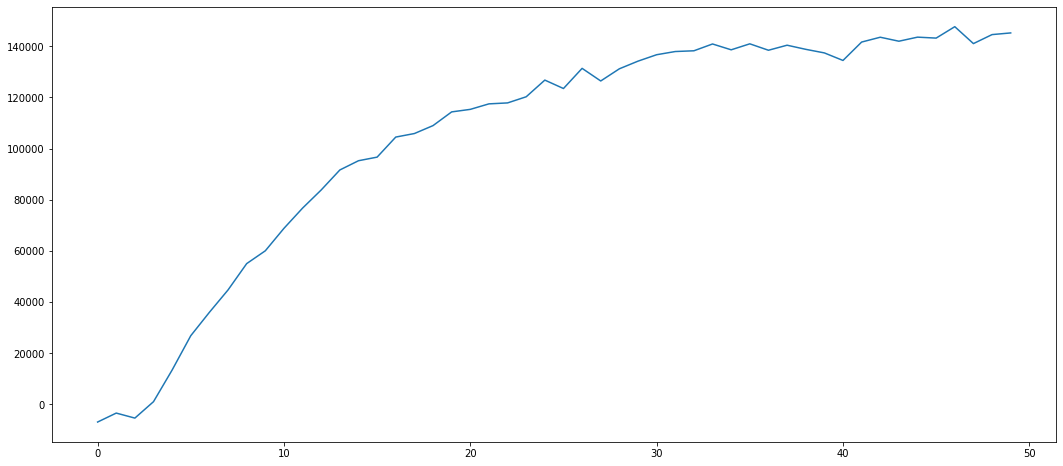


Number of context transitions in customer base 2651

Average response rate


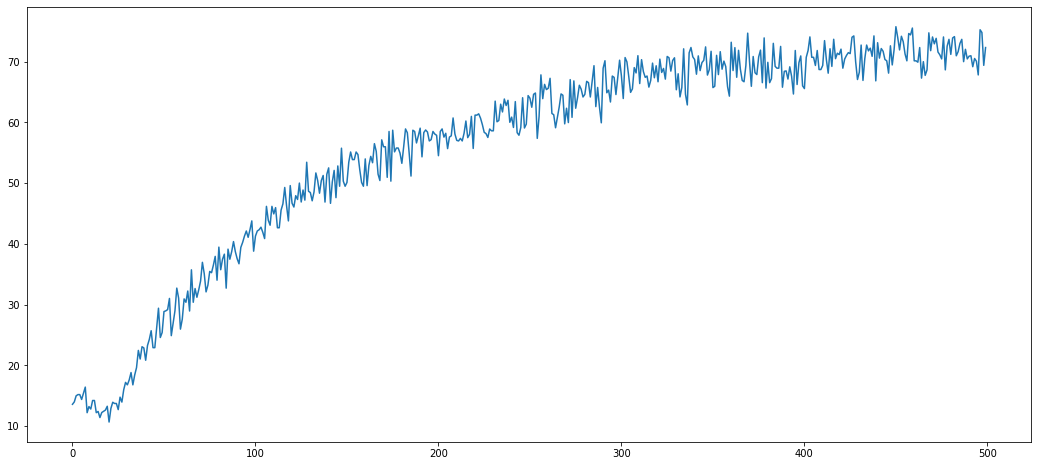

Response rate at 60 days: 15.430861723446894


In [41]:
NUM_CUSTOMERS = 500
customers = [histogram_to_probability(cust) for cust in gmm.sample(NUM_CUSTOMERS)[0]]
env = CustomerBaseFinalForm(customers, 500, -100, ctp=0.01)
agent = DQNAgent(env,gamma=0.5, n_nodes=128, epsilon_decay=0.993, learning_rate=0.001)

TARGET_UPDATE_FREQ = NUM_CUSTOMERS

total_steps = 0

obs = env.reset()
scores = []
avg_score = []
response_rate = []

for i in range(500):
    done = False
    episode_reward = 0
    responses = 0
    obs = env.reset()
    
    while not done:
        total_steps = total_steps + 1
        action = agent.choose_action(agent.customer_profiles[obs,:])
        new_obs, rew, done, _ = env.step(obs, action)
        #print(obs, new_obs, done)
        #print(action)
        if rew > 0:
            responses = responses + 1
            agent.customer_profiles[obs, action] = agent.customer_profiles[obs, action] + 0.3
        elif rew < 0:
            agent.customer_profiles[obs, action] = agent.customer_profiles[obs, action] - 0.3

        transition = (agent.customer_profiles[obs,:], action, rew, done,
                      agent.customer_profiles[new_obs,:])

        agent.store_transition(transition)
        obs = new_obs
        agent.learn()
        episode_reward = episode_reward + rew


        if total_steps % TARGET_UPDATE_FREQ == 0:
            agent.target_net.load_state_dict(agent.online_net.state_dict())

    agent.decay_exploration()
    agent.rew_buffer.append(episode_reward)
    scores.append(episode_reward)
    response_rate.append(responses * 100 / (NUM_CUSTOMERS - np.sum(env.opt_out)))
    
    # Logging
    if i % 10 == 0:
        avg_score.append(np.mean(scores[-10:]))
        print()
        print('Episode', i + 10)
        print('Average reward', np.mean(scores[-10:]), 'Epsilon',agent.epsilon)

print("\nAverage reward every 10 steps")
plt.plot(avg_score)
plt.show()

print("\nNumber of context transitions in customer base", env.num_transitions)
print("\nAverage response rate")
plt.plot(response_rate)
plt.show()

print("Response rate at 60 days:", response_rate[6])

#### 5.8.1 Attempting to use a pre-trained neural network on a new customer base.


Episode 10
Average reward 11600.0 Epsilon 0.1

Episode 20
Average reward 9360.0 Epsilon 0.1

Episode 30
Average reward 39770.0 Epsilon 0.1

Episode 40
Average reward 54110.0 Epsilon 0.1

Episode 50
Average reward 61210.0 Epsilon 0.1

Episode 60
Average reward 64710.0 Epsilon 0.1

Episode 70
Average reward 66010.0 Epsilon 0.1

Episode 80
Average reward 69080.0 Epsilon 0.1

Episode 90
Average reward 70930.0 Epsilon 0.1

Episode 100
Average reward 73380.0 Epsilon 0.1

Episode 110
Average reward 76290.0 Epsilon 0.1

Episode 120
Average reward 77240.0 Epsilon 0.1

Episode 130
Average reward 79500.0 Epsilon 0.1

Episode 140
Average reward 78470.0 Epsilon 0.1

Episode 150
Average reward 80190.0 Epsilon 0.1

Episode 160
Average reward 83760.0 Epsilon 0.1

Episode 170
Average reward 80900.0 Epsilon 0.1

Episode 180
Average reward 79100.0 Epsilon 0.1

Episode 190
Average reward 83960.0 Epsilon 0.1

Episode 200
Average reward 87000.0 Epsilon 0.1

Episode 210
Average reward 85920.0 Epsilon 0.1

E

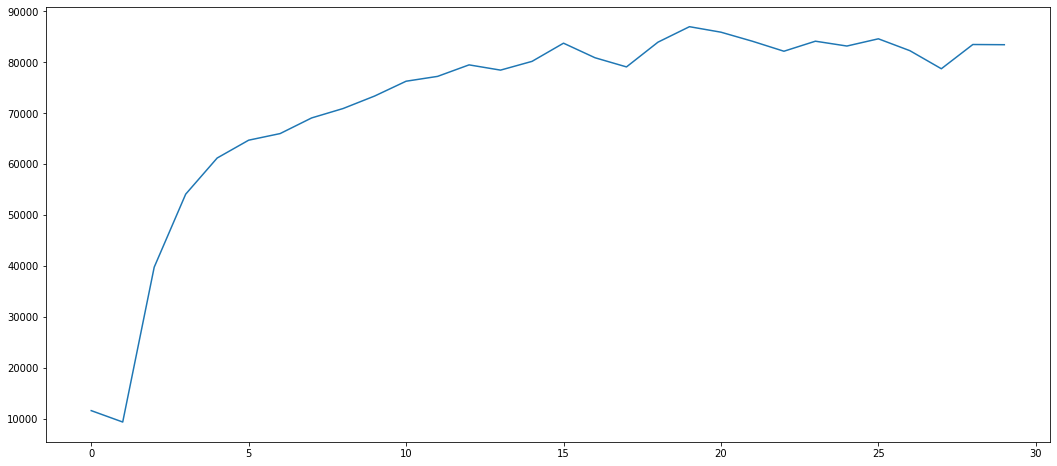


Number of context transitions in customer base 936

Average response rate


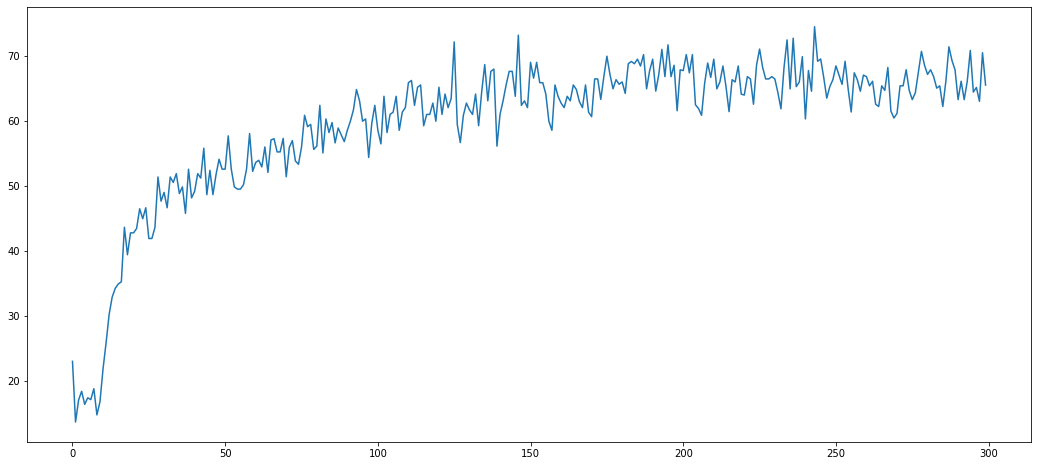

Response rate at 60 days: 17.114093959731544


In [46]:
NUM_CUSTOMERS = 300
customers = [histogram_to_probability(cust) for cust in gmm.sample(NUM_CUSTOMERS)[0]]
env = CustomerBaseFinalForm(customers, 500, -100, ctp=0.01)

TARGET_UPDATE_FREQ = NUM_CUSTOMERS

agent.customer_profiles = np.random.rand(env.n_states, env.n_actions - 1)
agent.epsilon = 0.1

total_steps = 0

obs = env.reset()
scores = []
avg_score = []
response_rate = []

for i in range(300):
    done = False
    episode_reward = 0
    responses = 0
    obs = env.reset()
    
    while not done:
        total_steps = total_steps + 1
        action = agent.choose_action(agent.customer_profiles[obs,:])
        new_obs, rew, done, _ = env.step(obs, action)
        #print(obs, new_obs, done)
        #print(action)
        if rew > 0:
            responses = responses + 1
            agent.customer_profiles[obs, action] = agent.customer_profiles[obs, action] + 0.3
        elif rew < 0:
            agent.customer_profiles[obs, action] = agent.customer_profiles[obs, action] - 0.3

        transition = (agent.customer_profiles[obs,:], action, rew, done,
                      agent.customer_profiles[new_obs,:])

        agent.store_transition(transition)
        obs = new_obs
        agent.learn()
        episode_reward = episode_reward + rew


        if total_steps % TARGET_UPDATE_FREQ == 0:
            agent.target_net.load_state_dict(agent.online_net.state_dict())

    # agent.decay_exploration()
    agent.rew_buffer.append(episode_reward)
    scores.append(episode_reward)
    response_rate.append(responses * 100 / (NUM_CUSTOMERS - np.sum(env.opt_out)))
    
    # Logging
    if i % 10 == 0:
        avg_score.append(np.mean(scores[-10:]))
        print()
        print('Episode', i + 10)
        print('Average reward', np.mean(scores[-10:]), 'Epsilon',agent.epsilon)

print("\nAverage reward every 10 steps")
plt.plot(avg_score)
plt.show()

print("\nNumber of context transitions in customer base", env.num_transitions)
print("\nAverage response rate")
plt.plot(response_rate)
plt.show()

print("Response rate at 60 days:", response_rate[6])